Notebook for testing and development of ISC/ FDSN scraper

In [1]:
%load_ext autoreload
%autoreload 2
import obspy
from obspy.clients.fdsn.client import Client
from obspy import UTCDateTime
from obspy.geodetics import locations2degrees

In [2]:
stla = 8.8
stlo = 38.68
start = UTCDateTime("2001-01-01T00:00:00")
end = UTCDateTime("2022-01-01T00:00:00")

In [3]:
client = Client('IRIS')
events = client.get_events(starttime=start, endtime=end, minmagnitude=5.5,
     maxmagnitude=7, catalog="ISC", latitude=stla, longitude=stlo,
     minradius=95, maxradius=120, magnitudetype="MW")
print(len(events))

2400


In [4]:
events_over95 = []
n = 0
max_dist = 0

for i, event in enumerate(events):
    dist = locations2degrees(stla, stlo, event.origins[0].latitude, event.origins[0].longitude)
    if dist >= 95:
        events_over95.append(event)
        n+=1
        if dist > max_dist:
            max_dist = dist
    
print(max_dist)        
print(n)
print(len(events_over95))

119.91614342075106
2370
2370


Make a random selection of 5 events for dev/testing purposes (so we dont have to use the full catalog)

In [5]:
import numpy as np

In [6]:
np.random.seed(112)
ind = np.random.randint(0,2400,5)
subset_list = []
for i, event in enumerate(events):
    if i in ind:
        subset_list.append(event)

In [7]:
subset = obspy.Catalog(subset_list)

In [8]:
subset.write('Test_data.xml',format='QUAKEML')

In [9]:
for event in subset:
    print(event.origins)

[Origin(resource_id=ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=22500062"), time=UTCDateTime(2014, 4, 18, 18, 44, 18, 930000), longitude=-162.3453, latitude=67.6773, depth=18400.0, creation_info=CreationInfo(author='ISC'))]
[Origin(resource_id=ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=5319553"), time=UTCDateTime(2011, 5, 24, 17, 43, 23, 870000), longitude=-173.2413, latitude=52.5429, depth=141900.0, creation_info=CreationInfo(author='ISC'))]
[Origin(resource_id=ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=16824277"), time=UTCDateTime(2010, 6, 11, 16, 37, 50, 910000), longitude=142.6538, latitude=26.735, depth=28400.0, creation_info=CreationInfo(author='ISC'))]
[Origin(resource_id=ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=4859510"), time=UTCDateTime(2009, 3, 30, 12, 7, 27, 840000), longitude=-178.1844, latitude=51.4975, depth=31000.0, creation_info=CreationInfo(auth

In [10]:
t1 = events[0].origins[0].time

In [11]:
t1

2015-08-24T11:50:59.920000Z

In [12]:
import datetime
dt = datetime.timedelta(seconds=3000)


In [13]:
t2 = t1 + dt
print(t2)
print(t2 - t1)

2015-08-24T12:40:59.920000Z
3000.0


In [17]:
from query_events import query_waveforms

In [61]:
st = query_waveforms(subset.events[3], "FURI", loc_code="00")

In [65]:
for tr in st:
    sachdr = {'evlo':0, 'evla':20, 'stla':12, 'stlo':11, 'user0':1000}
    tr.stats.sac = sachdr
    tr.write(f'test.{tr.stats.channel}', format='SAC', byteorder='1')

In [66]:
st_in = obspy.read('test.BH?')

In [67]:
st_in[0].stats

         network: IU
         station: FURI
        location: 00
         channel: BHE
       starttime: 2009-03-30T12:07:27.860645Z
         endtime: 2009-03-30T12:37:27.810645Z
   sampling_rate: 20.0
           delta: 0.05
            npts: 36000
           calib: 1.0
         _format: SAC
             sac: AttribDict({'delta': 0.05, 'depmin': -1.3406287e-06, 'depmax': 3.710249e-07, 'b': 0.000645, 'e': 1799.9507, 'stla': 12.0, 'stlo': 11.0, 'evla': 20.0, 'evlo': 0.0, 'user0': 1000.0, 'dist': 1472.0115, 'az': 125.30851, 'baz': 308.35666, 'gcarc': 13.238117, 'depmen': -6.9087545e-09, 'nzyear': 2009, 'nzjday': 89, 'nzhour': 12, 'nzmin': 7, 'nzsec': 27, 'nzmsec': 860, 'nvhdr': 6, 'npts': 36000, 'iftype': 1, 'leven': 1, 'lpspol': 0, 'lovrok': 1, 'lcalda': 1, 'kstnm': 'FURI', 'khole': '00', 'kcmpnm': 'BHE', 'knetwk': 'IU'})

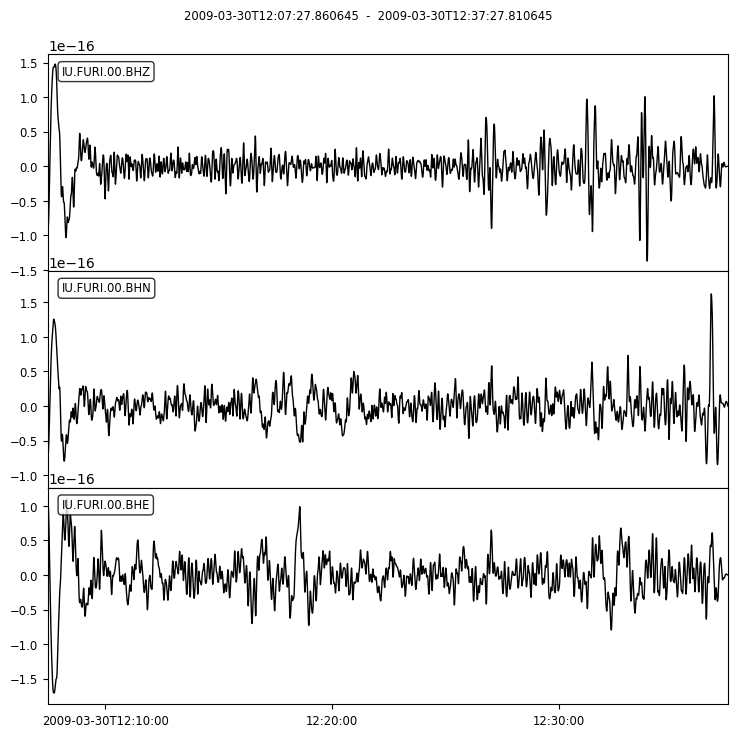

NameError: name 'plt' is not defined

In [54]:

st_cor = st.remove_response().copy()
st_cor.filter('bandpass',zerophase=True,freqmin=0.01,freqmax=0.1,corners=2)
st_cor.plot()
plt.show()

In [68]:
from obspy.io.sac import SACTrace

In [70]:
sactr = SACTrace.from_obspy_trace(st[0])

In [80]:
otime = subset.events[3].origins[0].time
sactr.o = otime
sactr.iztype = 'io'

In [87]:
sactr

SACTrace(b=0.020645, delta=0.05, e=1799.9507, evla=20.0, evlo=0.0, iftype=1, iztype=11, kcmpnm='BHE', khole='00', knetwk='IU', kstnm='FURI', lcalda=1, leven=1, lovrok=1, lpspol=0, npts=36000, nvhdr=6, nzhour=12, nzjday=89, nzmin=7, nzmsec=840, nzsec=27, nzyear=2009, o=0.0, stla=12.0, stlo=11.0, user0=1000.0)

In [85]:
evt = subset.events[3]
evt.origins[0]

Origin
	   resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=4859510")
	          time: UTCDateTime(2009, 3, 30, 12, 7, 27, 840000)
	     longitude: -178.1844
	      latitude: 51.4975
	         depth: 31000.0
	 creation_info: CreationInfo(author='ISC')

In [88]:
from obspy.taup import TauPyModel
model = TauPyModel('iasp91')

In [142]:
arrivals = model.get_travel_times(100, 100, phase_list=['SKS'])
print(arrivals)

1 arrivals
	SKS phase arrival at 1442.722 seconds


In [150]:
event.origins[0].time.second

4

In [138]:
from query_events import get_waveforms_for_catalog

station = {'name':'FURI', 'latitude': 8.895, 'longitude': 38.86} 

get_waveforms_for_catalog(subset, station, write_out=True, path='/Users/ja17375/Programs/eventscraper/dev')

In [120]:
subset

5 Event(s) in Catalog:
2014-04-18T18:44:18.930000Z | +67.677, -162.345 | 5.7  MW
2011-05-24T17:43:23.870000Z | +52.543, -173.241 | 5.5  MW
2010-06-11T16:37:50.910000Z | +26.735, +142.654 | 5.6  MW
2009-03-30T12:07:27.840000Z | +51.498, -178.184 | 5.7  MW
2001-04-02T06:50:04.070000Z | +11.845, +147.385 | 5.5  MW

In [119]:
st = obspy.read('FURI_2014108_184418.BH?')
st[0].stats

         network: IU
         station: FURI
        location: 00
         channel: BH1
       starttime: 2014-04-18T18:44:18.969538Z
         endtime: 2014-04-18T19:14:18.919538Z
   sampling_rate: 20.0
           delta: 0.05
            npts: 36000
           calib: 1.0
         _format: SAC
             sac: AttribDict({'delta': 0.05, 'depmin': -3.2414349e-07, 'depmax': 1.0020758e-06, 'scale': 1.0, 'b': 0.040537998, 'e': 1799.9906, 'o': 0.0009999983, 'stla': 8.895, 'stlo': 38.86, 'evla': 67.6773, 'evlo': -162.3453, 'evdp': 18.4, 'user0': 1468.6119, 'user1': 1473.6119, 'user2': 1483.6119, 'user3': 1488.6119, 'az': 338.6146, 'baz': 8.081196, 'gcarc': 102.02, 'depmen': 5.5479585e-09, 'nzyear': 2014, 'nzjday': 108, 'nzhour': 18, 'nzmin': 44, 'nzsec': 18, 'nzmsec': 929, 'nvhdr': 6, 'npts': 36000, 'iftype': 1, 'iztype': 11, 'leven': 1, 'lpspol': 1, 'lovrok': 1, 'lcalda': 0, 'kstnm': 'FURI', 'khole': '00', 'kcmpnm': 'BH1', 'knetwk': 'IU'})

In [141]:
obspy.taup.taup_geo.calc_dist_azi(67.6773,-162.3453,8.895, 38.86, 6371, 0)

(101.93546387510594, 338.5765953876509, 8.072250477930652)

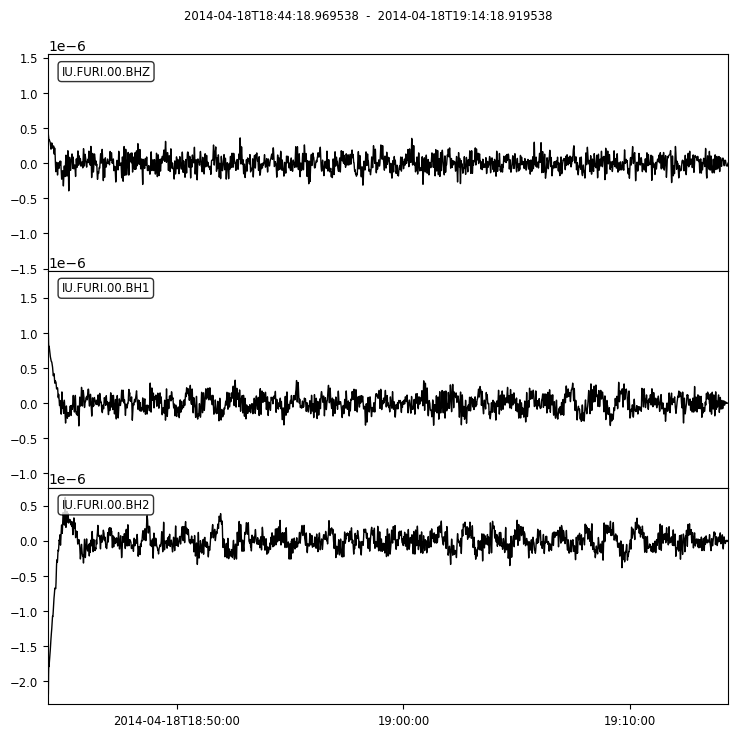

ValueError: With method '->ZNE' station metadata has to be provided as 'inventory' parameter.

In [124]:
st_t.plot()
st_t.rotate('->ZNE')

In [127]:
st_t[0].stats

               network: IU
               station: FURI
              location: 00
               channel: BH1
             starttime: 2014-04-18T18:44:18.969538Z
               endtime: 2014-04-18T19:14:18.919538Z
         sampling_rate: 20.0
                 delta: 0.05
                  npts: 36000
                 calib: 1.0
_fdsnws_dataselect_url: http://service.iris.edu/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'M', 'number_of_records': 146, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 233472})
            processing: ['ObsPy 1.4.0: trim(endtime=UTCDateTime(2014, 4, 18, 19, 14, 18, 919538)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2014, 4, 18, 18, 44, 18, 919538))', "ObsPy 1.4.0: remove_response(fig=None::inventory=None::output='VEL'::plot=False::pre_filt=None::taper=True::taper_fraction=0.05::water_level=60::zero_mean=True)", "ObsPy 1.4.0: filter(options={'

In [133]:
inv= client.get_stations(starttime=st_t[0].stats.starttime, endtime=st_t[0].stats.endtime, network='IU', sta='FURI', loc='00', channel='BH?', level='response')

In [134]:
st_t.rotate('->ZNE', inventory=inv)

3 Trace(s) in Stream:
IU.FURI.00.BHZ | 2014-04-18T18:44:18.969538Z - 2014-04-18T19:14:18.919538Z | 20.0 Hz, 36000 samples
IU.FURI.00.BHN | 2014-04-18T18:44:18.969538Z - 2014-04-18T19:14:18.919538Z | 20.0 Hz, 36000 samples
IU.FURI.00.BHE | 2014-04-18T18:44:18.969538Z - 2014-04-18T19:14:18.919538Z | 20.0 Hz, 36000 samples

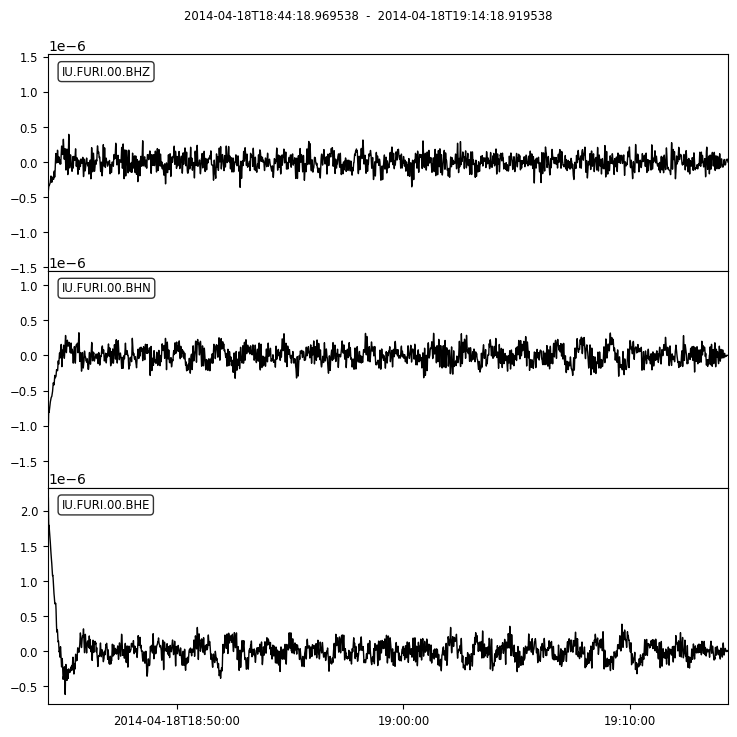

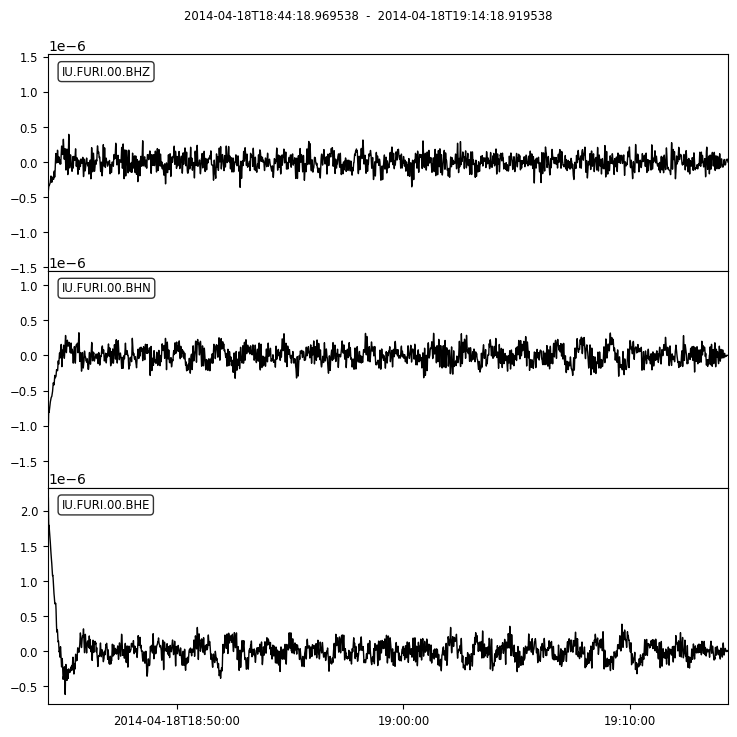

In [135]:
st_t.plot()